# I. INTRODUCTION

---
$$ Face Recognition
$$
$$NAMA : Fajar Dawud
$$

url = https://www.kaggle.com/datasets/msambare/fer2013

Background: Teknologi telah berkembang pesat seiring dengan kemajuan dalam bidang Artificial Intelligence (AI) dan Deep Learning. Pengenalan wajah (Face Recognition) adalah teknologi yang memungkinkan sistem komputer untuk mengidentifikasi atau memverifikasi identitas seseorang berdasarkan wajah mereka.


Problem Statement: Teknologi Face Recognition semakin banyak digunakan dalam berbagai industri, mulai dari keamanan hingga layanan digital. Maka saya akan membuat model untuk mengidentifikasi ekspresi dari wajah seseorang yang bisa bermanfaat dalam berbagai hal seperti terapi psikologi dan customer experience monitoring di toko ritel.

Objectiv & Kegunaan :  
1. Membangun Model Face Recognition yang Akurat
2. Menangani Variasi dalam Pengenalan Wajah
3. Mengembangkan Aplikasi Berbasis Face Recognition

# II. IMPORT LIBRARIES



In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras.initializers import HeNormal, GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import cv2
import tensorflow as tf
from pathlib import Path

# Check TensorFlow version
print(tf.__version__)

2.18.0


# III. Data Loading

In [8]:
zip_path = "/content/archive (1).zip"  # Sesuaikan dengan lokasi file ZIP
extract_path = "/content/face_recognition2"  # Folder tujuan ekstraksi

# Ekstrak file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [9]:
#define train test
train_path = "/content/face_recognition2/train/"
test_path = "/content/face_recognition2/test/"

# IV. Eksploratory Data Analyst

## 1. Value & Object Composition

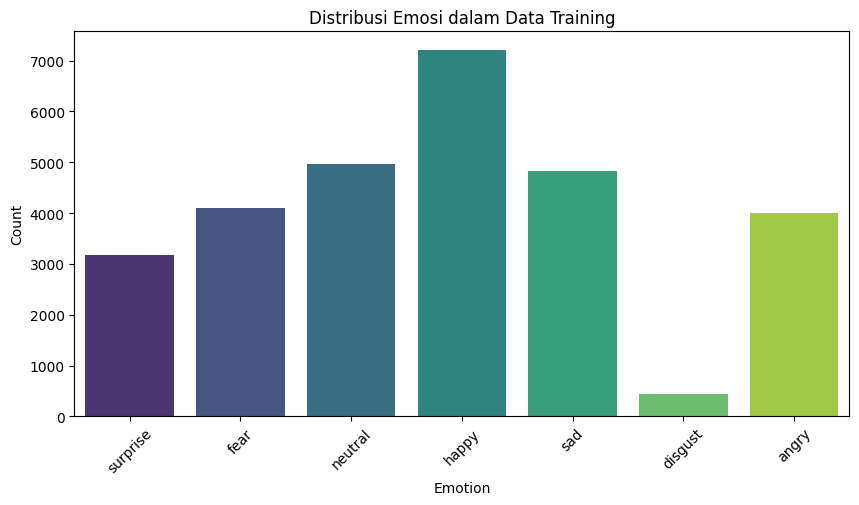

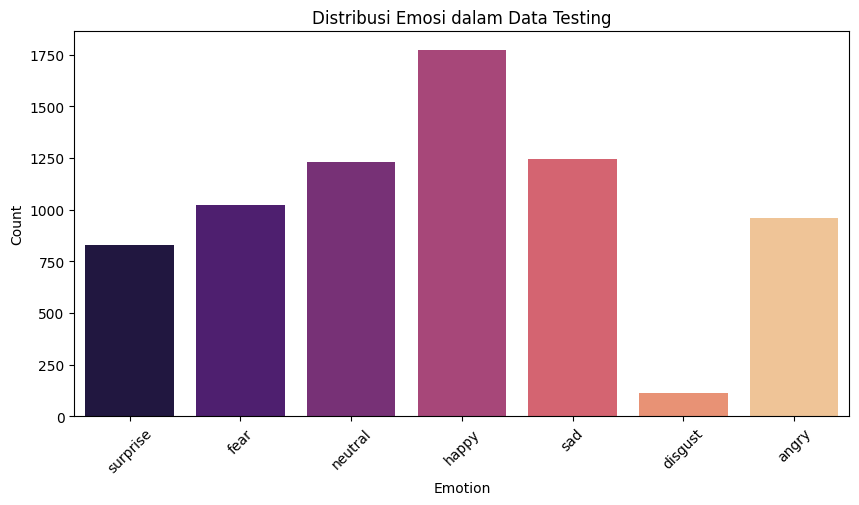

In [10]:
def count_images_in_folders(path):
    class_counts = {class_name: len(os.listdir(os.path.join(path, class_name)))
                    for class_name in os.listdir(path) if os.path.isdir(os.path.join(path, class_name))}
    return class_counts

train_counts = count_images_in_folders(train_path)
test_counts = count_images_in_folders(test_path)

# Visualisasi distribusi kelas
df_train = pd.DataFrame(list(train_counts.items()), columns=['Emotion', 'Count'])
df_test = pd.DataFrame(list(test_counts.items()), columns=['Emotion', 'Count'])

plt.figure(figsize=(10, 5))
sns.barplot(x='Emotion', y='Count', data=df_train, palette='viridis')
plt.title("Distribusi Emosi dalam Data Training")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Emotion', y='Count', data=df_test, palette='magma')
plt.title("Distribusi Emosi dalam Data Testing")
plt.xticks(rotation=45)
plt.show()

di dalam data training dan testing sama-sama menunjukkan bahwa class 'happy' lebih dominan daripada yang lain, dan nilai yang paling kecil yaitu adalah class 'disgusting'. Hal ini mungkin akan berpengaruh pada performa prediction dari 'disgusting' karena kurangnya data.

## 2. Composition

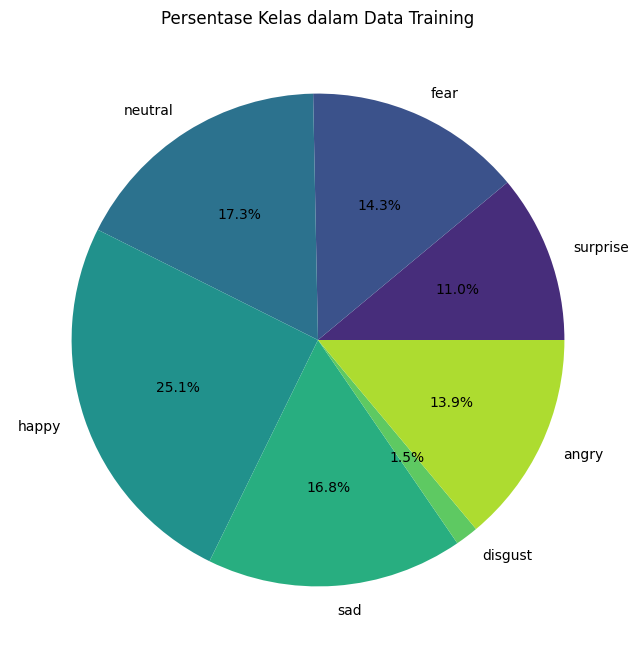

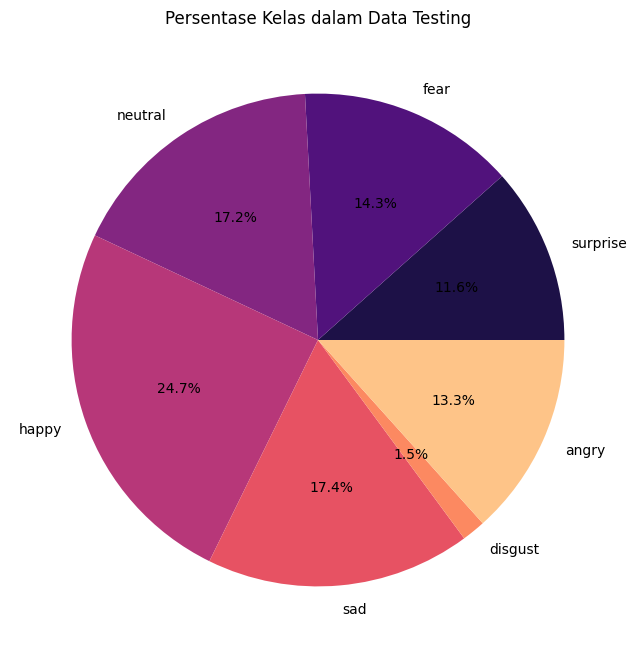

In [11]:
df_train['Percentage'] = (df_train['Count'] / df_train['Count'].sum()) * 100
df_test['Percentage'] = (df_test['Count'] / df_test['Count'].sum()) * 100

plt.figure(figsize=(8, 8))
plt.pie(df_train['Percentage'], labels=df_train['Emotion'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(df_train)))
plt.title("Persentase Kelas dalam Data Training")
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(df_test['Percentage'], labels=df_test['Emotion'], autopct='%1.1f%%', colors=sns.color_palette('magma', len(df_test)))
plt.title("Persentase Kelas dalam Data Testing")
plt.show()

Begitu pula ketika saya cek presentase nya, komposisi dari class 'happy' menunjukkan 24,7% lebih dominan dari yang lain.

## 3. Saturation

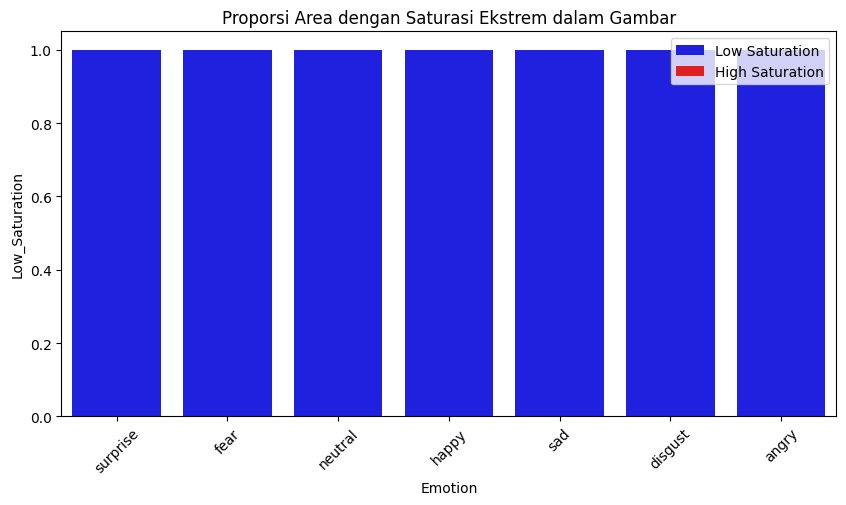

In [12]:
def extreme_saturation(image_path, low_thresh=30, high_thresh=200):
    img = cv2.imread(image_path)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = img_hsv[:, :, 1]

    low_sat_ratio = np.sum(saturation < low_thresh) / saturation.size
    high_sat_ratio = np.sum(saturation > high_thresh) / saturation.size

    return low_sat_ratio, high_sat_ratio

extreme_values = {'Emotion': [], 'Low_Saturation': [], 'High_Saturation': []}
for emotion in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, emotion)):
        image_files = os.listdir(os.path.join(train_path, emotion))
        image_paths = [os.path.join(train_path, emotion, img) for img in image_files[:10]]

        low_sats, high_sats = zip(*[extreme_saturation(img) for img in image_paths])

        extreme_values['Emotion'].append(emotion)
        extreme_values['Low_Saturation'].append(np.mean(low_sats))
        extreme_values['High_Saturation'].append(np.mean(high_sats))

df_extreme = pd.DataFrame(extreme_values)

plt.figure(figsize=(10, 5))
sns.barplot(x='Emotion', y='Low_Saturation', data=df_extreme, color='blue', label='Low Saturation')
sns.barplot(x='Emotion', y='High_Saturation', data=df_extreme, color='red', label='High Saturation')
plt.legend()
plt.title("Proporsi Area dengan Saturasi Ekstrem dalam Gambar")
plt.xticks(rotation=45)
plt.show()

Pada bagian ini terlihat bahwa semua class memiliki status low saturation yang mana dikarenakan semua gambar di dalam dataset ini berbentuk greyscale

## 4. Cek apakah ada gambar yang non Greyscale

In [13]:
folder_path = '/content/face_recognition2/train/'
def check_image_modes(folder_path):
    total = 0
    grayscale_count = 0
    non_grayscale_files = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                total += 1
                try:
                    img = Image.open(path)
                    if img.mode == 'L':
                        grayscale_count += 1
                    else:
                        if len(non_grayscale_files) < 5:
                            non_grayscale_files.append(f"{path} (mode: {img.mode})")
                except:
                    pass  # abaikan error gambar rusak

    print(f"Total gambar       : {total}")
    print(f"Grayscale          : {grayscale_count}")
    print(f"Non-Grayscale      : {total - grayscale_count}")

    if non_grayscale_files:
        print("\nContoh Non-Grayscale:")
        for f in non_grayscale_files:
            print(f"- {f}")

check_image_modes(folder_path)

Total gambar       : 28709
Grayscale          : 28709
Non-Grayscale      : 0


In [14]:
folder_path = '/content/face_recognition2/test/'
def check_image_modes(folder_path):
    total = 0
    grayscale_count = 0
    non_grayscale_files = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                total += 1
                try:
                    img = Image.open(path)
                    if img.mode == 'L':
                        grayscale_count += 1
                    else:
                        if len(non_grayscale_files) < 5:
                            non_grayscale_files.append(f"{path} (mode: {img.mode})")
                except:
                    pass  # abaikan error gambar rusak

    print(f"Total gambar       : {total}")
    print(f"Grayscale          : {grayscale_count}")
    print(f"Non-Grayscale      : {total - grayscale_count}")

    if non_grayscale_files:
        print("\nContoh Non-Grayscale:")
        for f in non_grayscale_files:
            print(f"- {f}")

check_image_modes(folder_path)

Total gambar       : 7178
Grayscale          : 7178
Non-Grayscale      : 0


dari eda nomor 5 menunjukkan bahwa  semua data greyscale, maka untuk color channel hanya ada 1.

# V. Feature Engineering

## 1. Data Augmentation

### A. Combining All Together

In [15]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=120,
    zoom_range=[0.3, 1.5],
    shear_range=50,
    validation_split=0.4
)

train = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    color_mode='grayscale',     # karena untuk gambar grayscale
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=2
)

val = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=2
)

Found 17227 images belonging to 7 classes.
Found 11482 images belonging to 7 classes.


saya pilih combine all together karena lebih general,lebih ringkas, kompleks, dan juga menghindari overfit

In [16]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 7178 images belonging to 7 classes.


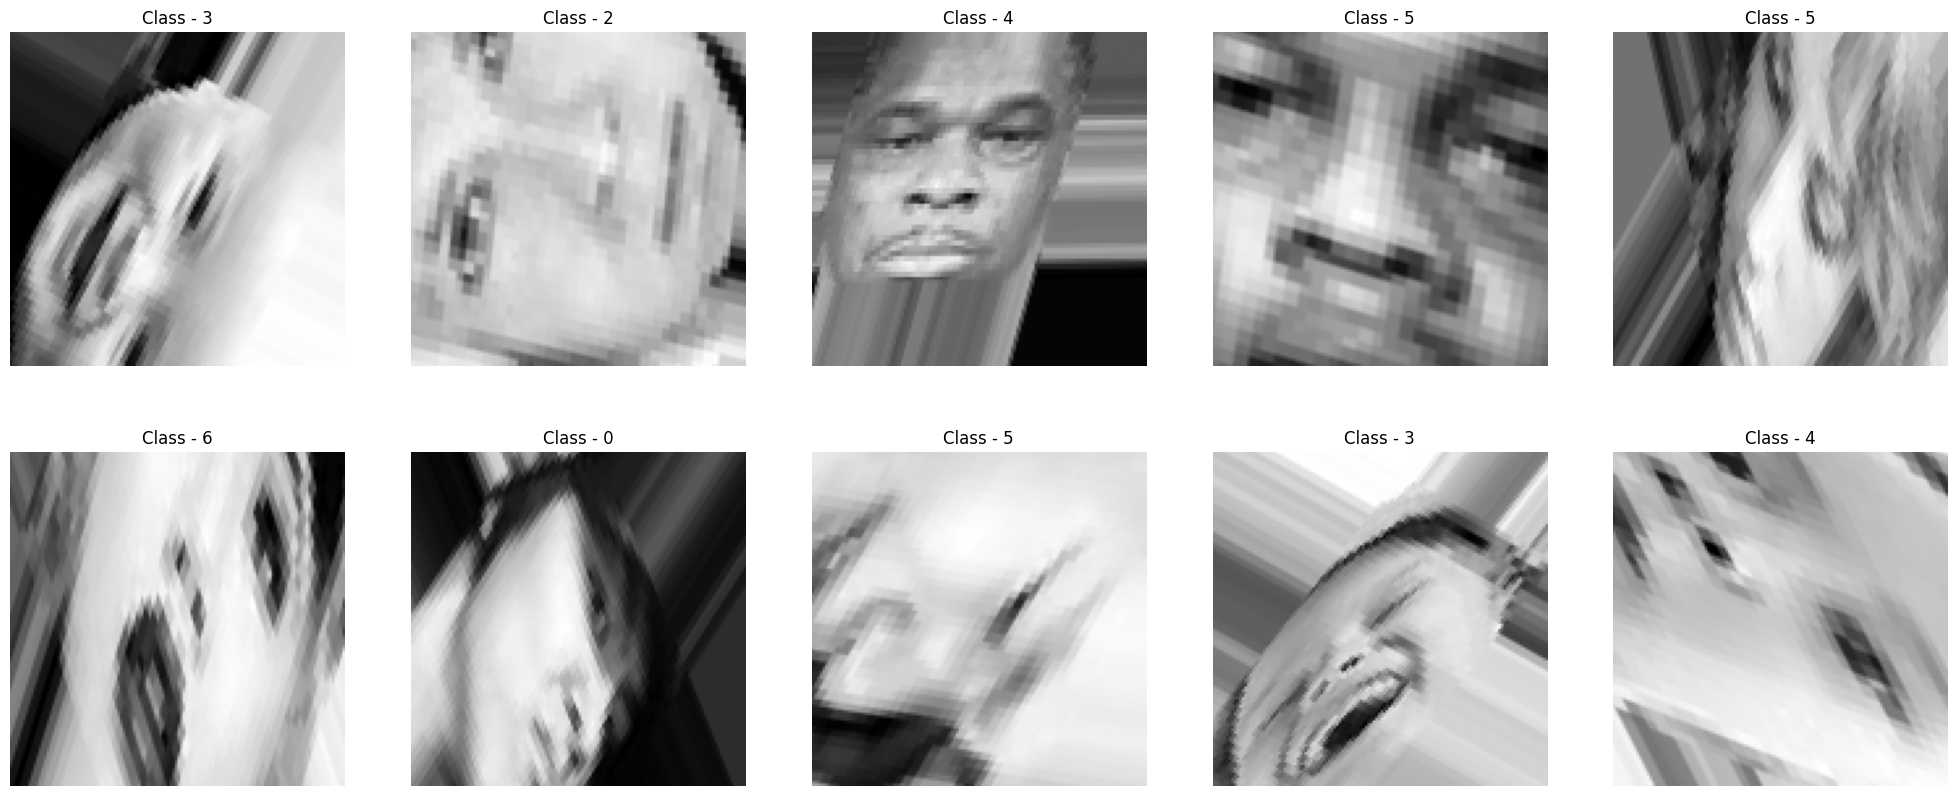

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
n = 0

batch = next(train)
images, labels = batch

for i in range(2):
    for j in range(5):
        img = images[n].squeeze()
        ax[i][j].imshow(img, cmap='gray')  # Menampilkan gambar dalam grayscale
        ax[i][j].set_title('Class - ' + str(labels[n].argmax()))
        ax[i][j].axis('off')
        n += 1

plt.show()


# VI. ANN TRAINING

## - SEQUENTIAL

### MODEL DEFINITION

In [18]:
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [19]:
#Define The model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1), padding='same'),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu', kernel_initializer=HeNormal(42)),
    Dropout(0.5),
    Dense(7, activation='softmax', kernel_initializer=GlorotNormal(42))
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,798,087 (64.08 MB)

 Trainable params: 16,798,087 (64.08 MB)

 Non-trainable params: 0 (0.00 B)

### MODEL TRAINING

lakukan training

In [20]:
history = model.fit(
    train,
    validation_data=val,
    epochs=15,
    steps_per_epoch=len(train),
    validation_steps=len(val)
)

Epoch 1/15
539/539 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.2326 - loss: 1.9676 - val_accuracy: 0.2516 - val_loss: 1.7938
Epoch 2/15
539/539 ━━━━━━━━━━━━━━━━━━━━ 761s 1s/step - accuracy: 0.2458 - loss: 1.8048 - val_accuracy: 0.2528 - val_loss: 1.7874
Epoch 3/15
539/539 ━━━━━━━━━━━━━━━━━━━━ 779s 1s/step - accuracy: 0.2534 - loss: 1.7940 - val_accuracy: 0.2540 - val_loss: 1.7890
Epoch 4/15
539/539 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - accuracy: 0.2511 - loss: 1.7928 - val_accuracy: 0.2544 - val_loss: 1.7869
Epoch 5/15
539/539 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.2498 - loss: 1.7916 - val_accuracy: 0.2546 - val_loss: 1.7881
Epoch 6/15
539/539 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.2537 - loss: 1.7866 - val_accuracy: 0.2523 - val_loss: 1.7870
Epoch 7/15
539/539 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.2489 - loss: 1.7885 - val_accuracy: 0.2563 - val_loss: 1.7812
Epoch 8/15
539/539 ━━━━━━━━━━━━━━━━━━━━ 786s 1s/step - accuracy: 0.2532 - loss: 1.7901 - val_accu

### MODEL EVALUATION

In [21]:
loss, acc = model.evaluate(test, steps=len(test))
print(f"\n Test Accuracy: {acc:.4f}")
print(f" Test Loss: {loss:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 61s 271ms/step - accuracy: 0.2251 - loss: 1.8507

 Test Accuracy: 0.2562
 Test Loss: 1.7627


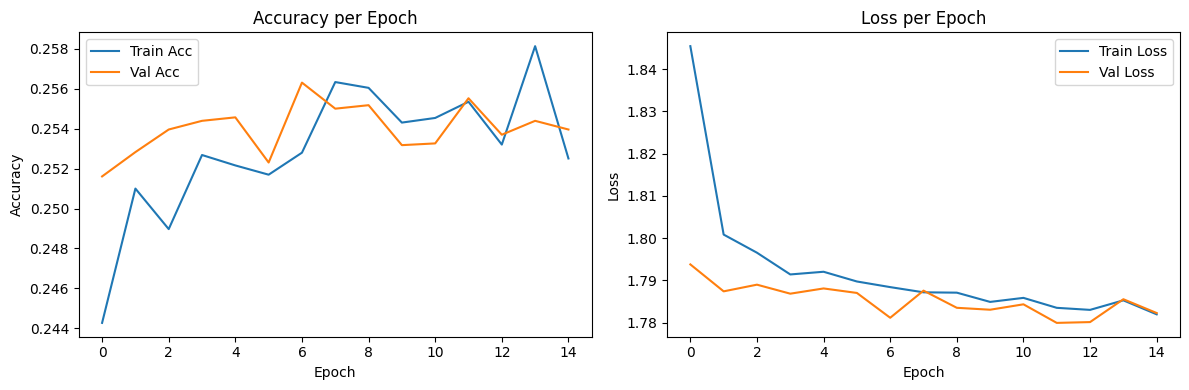

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

hasil dari training sangat buruk, maka perlu dilakukan model improvement dengan menambahkan layering

## - MODEL IMPROVEMENT

In [23]:
#Define the model improvement
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),

    Dense(512, activation='relu', kernel_initializer=HeNormal(42)),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_initializer=HeNormal(42)),
    Dropout(0.3),

    Dense(7, activation='softmax', kernel_initializer=GlorotNormal(42))
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,937,863 (64.61 MB)

 Trainable params: 16,937,415 (64.61 MB)

 Non-trainable params: 448 (1.75 KB)

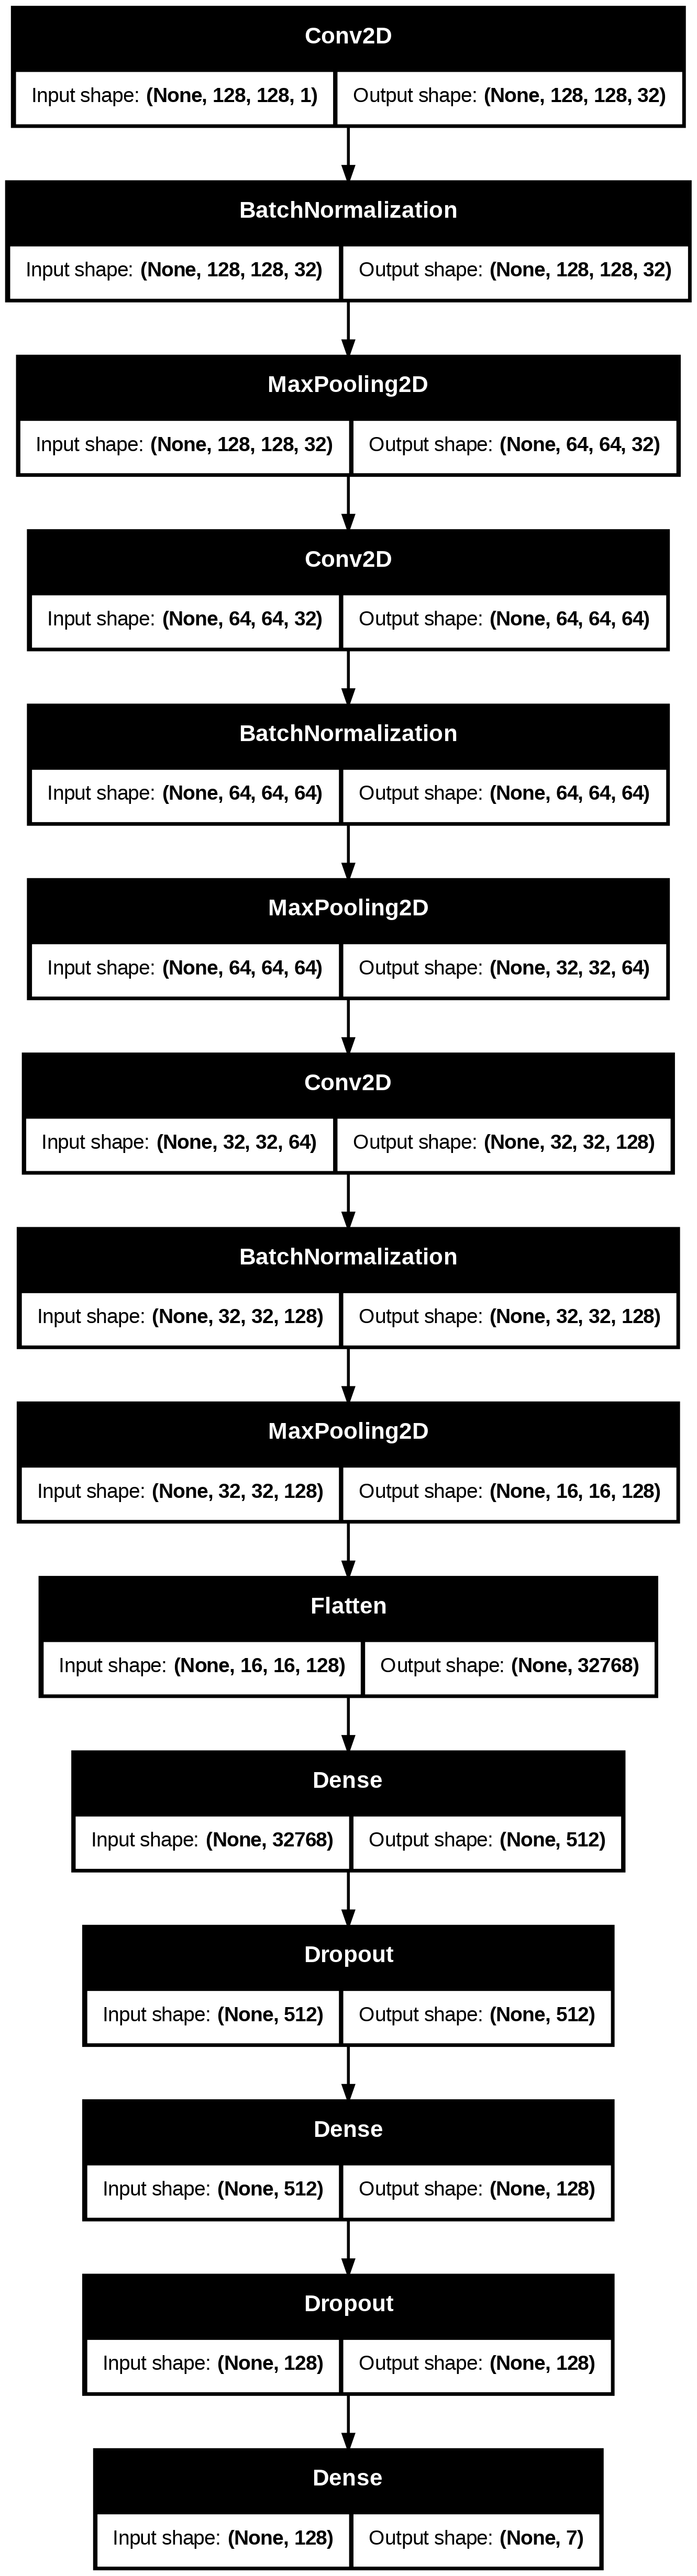

In [43]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

### Training improvement

In [24]:
# Training model
history = model.fit(
    train,
    validation_data=val,
    epochs=10,
    steps_per_epoch=len(train),
    validation_steps=len(val),
    verbose=1
)

Epoch 1/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 1331s 2s/step - accuracy: 0.1970 - loss: 5.8337 - val_accuracy: 0.2466 - val_loss: 1.8674 - learning_rate: 0.0010
Epoch 2/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 1324s 2s/step - accuracy: 0.2432 - loss: 1.8719 - val_accuracy: 0.2513 - val_loss: 1.8319 - learning_rate: 0.0010
Epoch 3/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 1347s 2s/step - accuracy: 0.2470 - loss: 1.8340 - val_accuracy: 0.2513 - val_loss: 1.8199 - learning_rate: 0.0010
Epoch 4/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 1334s 2s/step - accuracy: 0.2539 - loss: 1.8162 - val_accuracy: 0.2513 - val_loss: 1.8147 - learning_rate: 0.0010
Epoch 5/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 1340s 2s/step - accuracy: 0.2518 - loss: 1.8223 - val_accuracy: 0.2513 - val_loss: 1.8121 - learning_rate: 0.0010
Epoch 6/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 1359s 3s/step - accuracy: 0.2517 - loss: 1.8142 - val_accuracy: 0.2513 - val_loss: 1.8108 - learning_rate: 0.0010
Epoch 7/10
539/539 ━━━━━━━━━━━━━━━━━━━━ 1384s 2s/step - accuracy: 0.2496 - l

### Training Evaluation

In [25]:
loss, acc = model.evaluate(test, steps=len(test))
print(f"\n Test Accuracy: {acc:.4f}")
print(f" Test Loss: {loss:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 92s 409ms/step - accuracy: 0.2218 - loss: 1.8766

 Test Accuracy: 0.2471
 Test Loss: 1.8132


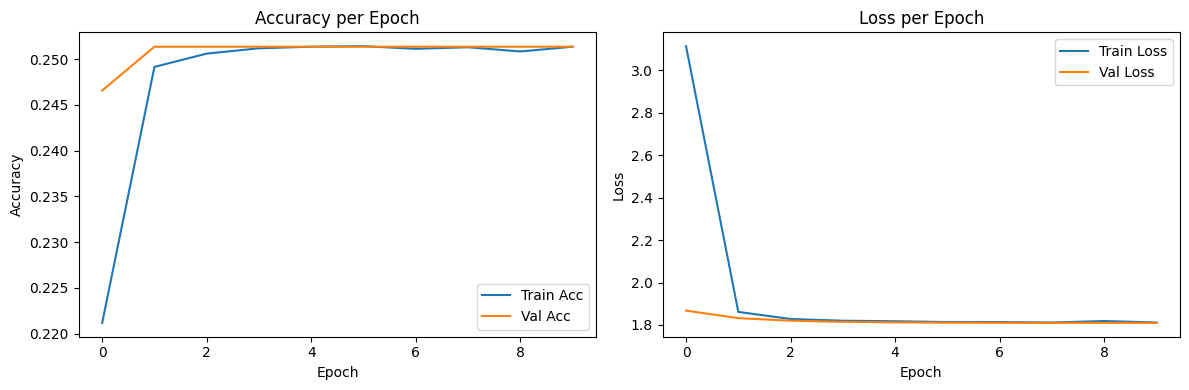

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

setelah dilakukan model improvement ternyata hasilnya masih sangat buruk yaitu overfit, disini terjadi mungkin karena pendefinisian parameter nya kurang optimal.

## MODEL SAVING

In [34]:
model.save('cnn_.keras')

## CONCLUSION

- Hasil dari model kali ini mungkin belum bisa dipakai atau diterapkan kedalam sistem aplikasi yang diminta oleh client, perbaikan dan penanganan perlu dilakukan lebih lanjut dengan waktu yang lebih.